[10.965368670501988, 14.198524584141133, 16.39857923621766, 16.474607037533215, 16.64053451779476, 16.815237373592854, 17.20801937719735, 17.315058668214707, 17.339557837684723, 17.46164374170204, 17.493970325578022, 17.58902537963803, 18.060312641770285, 18.26073255324264, 18.52738285206238, 18.59634684401101, 18.78586594003834, 18.87429354229012, 18.874848753130173, 19.163813889663786, 19.329395308160638, 19.423005545935663, 19.50441469492017, 19.522413079489905, 19.546685886253346, 19.795884466622628, 20.117584186465088, 20.170186178607064, 20.345741071576082, 20.408499355937554, 20.896676814050213, 20.90823329068409, 21.065780704646023, 21.35720750307468, 21.90220238527388, 21.964306914099954, 21.968012648610014, 21.96822864513934, 22.183479767507254, 22.424694880388838, 22.691402595907345, 22.831830100355376, 23.64608126010971, 23.80079164476615, 24.55089958386886, 24.97218942487701, 26.133817214136037, 26.272645323739965, 28.980342769299103]


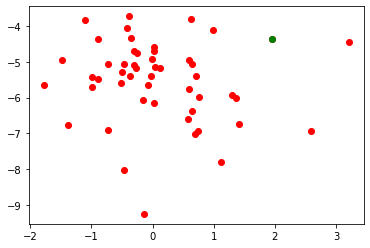

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
import random
import math
import matplotlib.pyplot as plt
from no_cluster import get_cluster
import copy

In [2]:
#random.seed(15)
P=2 #signal power threshold
#stream = BitStream()
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 50
        self.rounds = 200
        self.epochs = 5
        self.local_batches = 64
        self.lr = 0.0001
        self.C = 0.9 #fraction of clients used in the round
        self.drop_rate = 0.1 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'iid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.csi_low=0
        self.csi_high=1
 
args = Arguments()

In [4]:
#checking if gpu is available
use_cuda = False
#print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
clients = []

#generating virtual clients
for i in range(int(args.clients)):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
    
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

In [5]:
for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average

#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.FashionMNIST('./', train=True, download=True, transform=transform)
global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [6]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 128)  #10 iid 50 non iid
        self.fc2 = nn.Linear(128, 10) 

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



In [7]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        data=data*math.sqrt(poptim) #transmitted signal
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data,target=data,target
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                client['optim'].step()
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get() 
    #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        data=data*math.sqrt(poptim) #transmitted signal
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [8]:
def test(args, model, device, test_loader, name):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return(100. * correct / len(test_loader.dataset))


In [9]:
torch.manual_seed(args.torch_seed)
#global_model = Net() #redundant code as we don't use it for training: assigns a CNN to the global model

for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)
    

accuracy=[]
rc=1

[10.905215350651497, 12.716400799267944, 13.401434657941557, 13.507184173247428, 13.608461677332944, 13.6562775705455, 13.90888868153556, 13.980457862681842, 14.02213471572457, 14.066734458079488, 14.21342568656538, 14.257307521356893, 14.31548391640263, 14.504677735946316, 14.631435097078251, 15.073856287809308, 15.078933270854098, 15.13036185128102, 15.138351682701373, 15.167002557569207, 15.580682759965336, 15.712016058285958, 16.044578630963308, 16.07407763669414, 16.196467581773973, 16.302092346189966, 16.31296480955878, 16.3782113220841, 16.53547407258474, 17.228811537313174, 17.3469563663908, 17.446611312434516, 17.712032986630383, 17.799678593397676, 17.932836639375193, 18.190668086062946, 18.38097198252857, 18.435716842616436, 18.546828066045887, 18.621263210183173, 18.652003021794314, 18.708755644321275, 18.71989346711673, 19.680035596903046, 20.192065056103004, 20.441162288952324, 20.565544387022324, 21.288441403091813, 23.1195154867615]


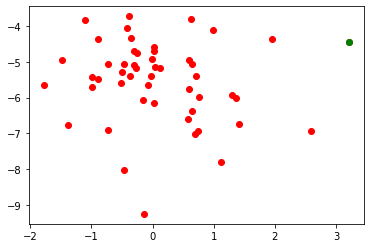

Power Allocated= 3.163885130065338
CSI= 0.9192734924680099
SNR= 10.905215350651497
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.09447689053098185
SNR= 12.716400799267944
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.03682641150636046
SNR= 13.401434657941557
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8008712308002743
CSI= 0.40802512807054847
SNR= 13.507184173247428
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.344599


/tmp/ipykernel_32836/1844779813.py:57: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informa

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.328866
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323062
Model client4 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.314906
Model client4 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.307870

Power Allocated= 3.1409130270162393
CSI= 0.9002620771562061
SNR= 13.608461677332944
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.004056256864189756
CSI= 0.2354246025135942
SNR= 13.6562775705455
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305581
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.362539
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.345949
Model client6 Train Epoch: 4 [0/1216 (0%)]	Loss: 2.281359
Model client6 Train Epoch: 5 [0/1216 (0%)]	Loss: 2.280491

Power Allocated= 2.682812013729274
CSI= 0.6373938580379257
SNR= 13.90888868153556
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8658606212701203
CSI= 0.721583990521839

KeyboardInterrupt: 

In [10]:
for fed_round in range(args.rounds):
    
    client_good_channel=[] #to check which clients have a good channel, only those will be taken for averaging per round

    # Training 
    #even slot
    
    snr=[] #snr of the channel
    csi=[] #csi of the channel
    for ii in range (int(args.clients)-1):
        #snr.append(random.uniform(args.snr_low, args.snr_high))
        csi.append(random.uniform(args.csi_low,args.csi_high))
    
    # if(fed_round==0):
    #     snr,cluster_head=get_cluster()
    if(fed_round==0): #fed_round==0 or True                                        %%%static or moving
        snr,cluster_head=get_cluster()
        temp=copy.deepcopy(cluster_head)
        temp1=copy.deepcopy(snr)
    else:
        #print(temp)
        cluster_head=copy.deepcopy(temp)
        snr=copy.deepcopy(temp1)
    #print(cluster_head)
    smallmu1=0
    gsmall1=3.402823466E+38 
    
    #water filling algorithm
    mu=1e-15
    while(mu<=1):
        #print("yay")
        #pn=max(1/mu-1/csi,0)
        g1=0
        pn1=0
        for jj in csi:
            pn=max(1/mu-1/jj,0)
            g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
            pn1+=pn
        g=g1-mu*(pn1-P*(int(args.clients)-1))
        if(g<gsmall1):
            smallmu1=mu
            gsmall1=g
        mu+=0.00002

    #print(smallmu1)
    # poptim=max(1/smallmu1-1/csi1,0)
    # print(poptim)
    index=0
    members=[]
    for i in clients:
        if(i['hook'].id!=cluster_head):
            members.append(i)
        else:
            head=i
    for client in members:
        goodchannel=ClientUpdate(args, device, client,key_np,key,snr[index],csi[index],smallmu1)
        if(goodchannel):
            client_good_channel.append(client)
        index+=1
        
    po=[]    
    for jj in csi:
        po.append(max(1/smallmu1-1/jj,0))
    
    plt.bar([str(i) for i in range (1,len(po)+1)],po,)
    csi.sort()
    po=[]
    for jj in csi:
        po.append(max(1/smallmu1-1/jj,0))
    fig,ax=plt.subplots()
    line1=ax.plot(csi,po,label="channel power allocated")
    line2=ax.plot(csi,[1/smallmu1]*len(csi),label="maximum power allocated")
    ax.set_title("csi vs power allocated")
    ax.set_xlabel("csi (channel gain to noise ratio)")
    ax.set_ylabel("power allocated")
    ax.legend()
    #plt.show()
    

#     # Testing 
#     for client in active_clients:
#         test(args, client['model'], device, client['testset'], client['hook'].id)
    
    
    
    print()
    print("Clients having a good channel and considered for training")
    for no in range (len(client_good_channel)):
        print(client_good_channel[no]['hook'].id)
        
        
        
    # Averaging 
        #odd slot

    head['model'] = averageModels(head['model'],client_good_channel)
    # Testing the average model
    #test(args, global_model, device, global_test_loader, 'Global')
    ac=test(args, head['model'], device, global_test_loader, 'Final')
    accuracy.append(ac)
    
    print("Power in training Round=",sum(po))
    #print("Power cap=",P*len(active_clients))
    
    #print("Total Power =",power_odd+power_even)
    print()
            
    # Share the global model with the clients
    index=0
    for client in members:
        client['model'].load_state_dict(head['model'].state_dict())
        #client=CLientReturn(client,snr[index],csi[index],smallmu1) #CHANGE:Commented
        index+=1
        #client['model']=torch.quantization.quantize_dynamic(client['model'],{torch.nn.Conv2d},dtype=torch.qint8)
        #print(client['model'].conv1.weight.data)
    fig1,ax1=plt.subplots()
    ax1.plot([i for i in range(len(accuracy))],accuracy)
    plt.show()
    print(rc)
    rc+=1

In [ ]:
print(accuracy)